This is the demonstration how to use NEDO data process utility

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from pypvcell.solarcell import SQCell,MJCell,TransparentCell
from pypvcell.illumination import Illumination
from pypvcell.spectrum import Spectrum

from pypvcell.metpv_reader import NEDOLocation

from pvlib.location import Location
from pvlib.tracking import SingleAxisTracker
from pvlib.irradiance import total_irrad,aoi_projection

In [2]:
nedo_solar_file='hm51106year.csv'

## Load the data into a ```NEDOLocation``` object

In [3]:
ngo_loc=NEDOLocation(nedo_solar_file)
df=ngo_loc.main_df

In [4]:
ngo_loc.main_df.head()

,measure_type,month,day,wind_speed,1,2,3,4,5,6,...,21,22,23,24,max,min,integral,avg,day_num,year
2016-01-01,1,1,1,17.9,0,0,0,0,0,0,...,0,0,0,0,175,NaN,926.0,NaN,1,2016
2016-01-01,2,1,1,17.9,0,0,0,0,0,0,...,0,0,0,0,118,NaN,500.0,NaN,1,2016
2016-01-01,3,1,1,17.9,0,0,0,0,0,0,...,0,0,0,0,77,NaN,426.0,NaN,1,2016
2016-01-01,4,1,1,17.9,0,0,0,0,0,0,...,0,0,0,0,10,NaN,52.0,NaN,1,2016
2016-01-01,5,1,1,17.9,31,21,17,12,11,17,...,51,41,49,49,104,11.0,NaN,48.0,1,2016


```main_df``` adds the column names into the raw data and convert it to a pandas.DataFrame object

## Convert the NEDO data into a more useful form
Add column names into the raw data does not make the dataframe easier to use. ```nedo_data_reader``` can "unstack" the data, i.e., making each row an entry of particular time.

In [5]:
%%time
ngo_df=ngo_loc.extract_unstack_hour_data(norm=False)

CPU times: user 11.5 s, sys: 174 ms, total: 11.7 s
Wall time: 11.7 s


In [6]:
ngo_df.head()

,GHI,DHI,dHI,sun_time,temperature,wind_dir,wind_speed,rain,snow,avg_time
avg_time,,,,,,,,,,
2016-01-01 00:30:00+09:00,0.0,0.0,0.0,0.0,31.0,10.0,47.0,0.0,0.0,2016-01-01 00:30:00+09:00
2016-01-01 01:30:00+09:00,0.0,0.0,0.0,0.0,21.0,10.0,37.0,0.0,0.0,2016-01-01 01:30:00+09:00
2016-01-01 02:30:00+09:00,0.0,0.0,0.0,0.0,17.0,10.0,20.0,0.0,0.0,2016-01-01 02:30:00+09:00
2016-01-01 03:30:00+09:00,0.0,0.0,0.0,0.0,12.0,3.0,19.0,0.0,0.0,2016-01-01 03:30:00+09:00
2016-01-01 04:30:00+09:00,0.0,0.0,0.0,0.0,11.0,14.0,24.0,0.0,0.0,2016-01-01 04:30:00+09:00


In [7]:
ngo_df.to_csv("ngo_df.csv")

### Calculate the overall insolation

In [8]:
ngo_df[['GHI','DHI','dHI']].sum()

GHI    504188.0
DHI    263011.0
dHI    241177.0
dtype: float64

### Extrat DNI
Daily METPV-11 data records the solar insolation on a horizontal plane. We can use ```get_DNI()``` to recalculate the DNI data.

In [9]:
ngo_dni=ngo_loc.get_DNI()

In [10]:
ngo_dni.head()

avg_time
2016-01-01 00:30:00+09:00   -0.0
2016-01-01 01:30:00+09:00   -0.0
2016-01-01 02:30:00+09:00   -0.0
2016-01-01 03:30:00+09:00   -0.0
2016-01-01 04:30:00+09:00   -0.0
dtype: float64

(0, 1000)

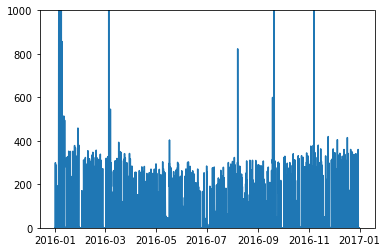

In [11]:
plt.plot(ngo_dni)
plt.ylim([0,1000])

## Calculate DNI on a tilted surface

In [12]:
ngo_tilt_irr=ngo_loc.tilt_irr(include_solar_pos=True)

In [13]:
ngo_tilt_irr.head()

,GHI,DHI,dHI,sun_time,temperature,wind_dir,wind_speed,rain,snow,avg_time,...,poa_sky_diffuse,poa_ground_diffuse,aoi,DNI,apparent_elevation,apparent_zenith,azimuth,elevation,equation_of_time,zenith
avg_time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:30:00+09:00,0.0,0.0,0.0,0.0,31.0,10.0,47.0,0.0,0.0,2016-01-01 00:30:00+09:00,...,0.0,0.0,153.413612,-0.0,-72.544908,162.544908,45.990508,-72.544908,-2.901565,162.544908
2016-01-01 01:30:00+09:00,0.0,0.0,0.0,0.0,21.0,10.0,37.0,0.0,0.0,2016-01-01 01:30:00+09:00,...,0.0,0.0,143.902222,-0.0,-62.146860,152.146860,70.266810,-62.146860,-2.921438,152.146860
2016-01-01 02:30:00+09:00,0.0,0.0,0.0,0.0,17.0,10.0,20.0,0.0,0.0,2016-01-01 02:30:00+09:00,...,0.0,0.0,131.815509,-0.0,-50.338026,140.338026,83.274763,-50.338026,-2.941303,140.338026
2016-01-01 03:30:00+09:00,0.0,0.0,0.0,0.0,12.0,3.0,19.0,0.0,0.0,2016-01-01 03:30:00+09:00,...,0.0,0.0,118.688199,-0.0,-38.225568,128.225568,92.549976,-38.225568,-2.961160,128.225568
2016-01-01 04:30:00+09:00,0.0,0.0,0.0,0.0,11.0,14.0,24.0,0.0,0.0,2016-01-01 04:30:00+09:00,...,0.0,0.0,105.108603,-0.0,-26.182925,116.182925,100.521619,-26.182925,-2.981010,116.182925


In [14]:
ngo_tilt_irr.columns

Index(['GHI', 'DHI', 'dHI', 'sun_time', 'temperature', 'wind_dir',
       'wind_speed', 'rain', 'snow', 'avg_time', 'poa_global', 'poa_direct',
       'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse', 'aoi', 'DNI',
       'apparent_elevation', 'apparent_zenith', 'azimuth', 'elevation',
       'equation_of_time', 'zenith'],
      dtype='object')

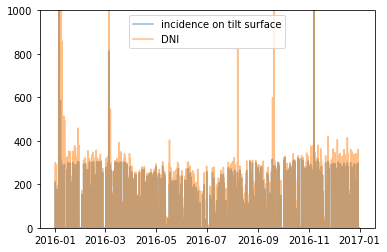

In [15]:
plt.plot(ngo_tilt_irr['poa_direct'],alpha=0.5,label='incidence on tilt surface')
plt.plot(ngo_dni,alpha=0.5,label='DNI')
plt.ylim([0,1000])
plt.legend()

### Visualize the sun irradiances in angular plot

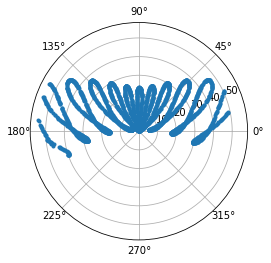

In [16]:
from matplotlib.colors import LogNorm
filtered_df=ngo_tilt_irr.loc[(ngo_tilt_irr['poa_direct']>1) & (ngo_tilt_irr['poa_direct']<500),
                             ["azimuth","zenith",'poa_direct']]
ax = plt.subplot(111, projection='polar')
ax.plot(filtered_df['azimuth'].values*np.pi/180-np.pi/2, 
        filtered_df['zenith'].values-ngo_loc.latitude,'.')
plt.show()

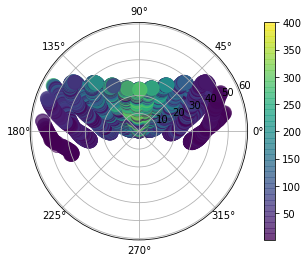

In [17]:
import matplotlib as mpl
filtered_df=ngo_tilt_irr.loc[(ngo_tilt_irr['poa_direct']>1) & (ngo_tilt_irr['poa_direct']<500),
                             ["azimuth","zenith",'poa_direct']]
ax = plt.subplot(111, projection='polar')
colormap = plt.get_cmap('hsv')
norm = mpl.colors.Normalize(1, 400)
cax=ax.scatter(filtered_df['azimuth'].values*np.pi/180-np.pi/2, filtered_df['zenith'].values-ngo_loc.latitude,
           c=filtered_df['poa_direct'].values,s=200,norm=norm,alpha=0.5)
plt.colorbar(cax)
plt.savefig("nagoya_angular.png",dpi=600)
plt.show()

### Analyze angle of incidence

In [18]:
ngo_tilt_irr.columns

Index(['GHI', 'DHI', 'dHI', 'sun_time', 'temperature', 'wind_dir',
       'wind_speed', 'rain', 'snow', 'avg_time', 'poa_global', 'poa_direct',
       'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse', 'aoi', 'DNI',
       'apparent_elevation', 'apparent_zenith', 'azimuth', 'elevation',
       'equation_of_time', 'zenith'],
      dtype='object')

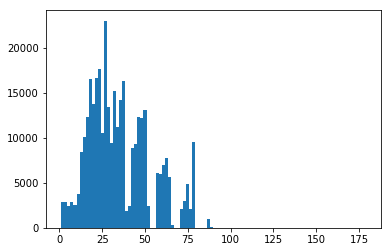

In [19]:
plt.hist(ngo_tilt_irr['aoi'],weights=ngo_tilt_irr['poa_direct'],bins=100)
plt.show()